In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from results import evaluate_decoded_files
import os, auxiliary_utils
import warnings
import logging
warnings.filterwarnings(action='ignore')
logging.getLogger('tensorflow').disabled = True
%matplotlib inline 
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
from tensor2tensor import models, problems
from tensor2tensor.utils import usr_dir, trainer_lib, registry
logger = tf.get_logger()
logger.propagate = False
Modes = tf.estimator.ModeKeys
usr_dir.import_usr_dir('./usr_dir/')
problem_name = "algebraic_word_problem"
model_name = 'seq_in_grid_out_architecture'
hparam_set = 'sigo_hparam_h128_l3_gru_acnn'
step = '64000'
trial = 4
shard = 0
split = "test"
batch_size = 2048
basic_path = '/media/disk1/ksk5693/sessions/t2t/'
data_dir = "/media/disk1/ksk5693/data/t2t_data/"  # data dir
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.95
%load_ext autoreload
%autoreload 2

/home/ksk5693/anaconda2/envs/tf1.13_py3.6/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

True algebraic_word_problem
True seq_in_grid_out_architecture
True sigo_hparam_h128_l3_gru_acnn


In [2]:
tf.reset_default_graph()
hparams, problem = auxiliary_utils.hparams_set_up(problem_name, data_dir, hparam_set)
encoders = problem.feature_encoders(data_dir)
hparams.batch_size = batch_size
output_dir = evaluate_decoded_files.compose_output_dir(basic_path, 
                                                       problem_name, 
                                                       model_name, 
                                                       hparam_set,
                                                       trial)
ckp = evaluate_decoded_files.get_ckpt(output_dir, step)

dataset_kwargs = {'dataset_split': split, 'shard': shard}
eval_input_fn = problem.make_estimator_input_fn(mode=tf.estimator.ModeKeys.EVAL, \
                                                hparams=hparams, \
                                                data_dir=data_dir, \
                                                dataset_kwargs=dataset_kwargs)

run_config = trainer_lib.create_run_config("None", model_dir=ckp)
input_iterator = eval_input_fn(hparams, run_config).make_one_shot_iterator()
translate_model = registry.model(model_name)(hparams, Modes.EVAL)
inputs, targets = input_iterator.get_next()
model_output = translate_model.infer(inputs)
interest = {"input": inputs["inputs"],
            "output": model_output,
            "targets": inputs["targets"]
           }
node_keywords = ["grid_structured_states", "action_seq"]
interest_node = dict([(op.name, op) for op in tf.contrib.graph_editor.get_tensors(tf.get_default_graph()) 
                     if auxiliary_utils.keyword_filter(node_keywords, op)])
interest.update(interest_node)
saver = tf.train.Saver()
with tf.Session(config=config) as sess:
    saver.restore(sess, ckp)  
    interest_np = auxiliary_utils.show_dict(interest, sess, squeeze=True)

input (60, 32, 1, 1)
output (60, 25, 1, 1)
targets (60, 15, 1, 1)
seq_in_grid_out_architecture/body/seq2grid/action_seq:0 (60, 32, 1, 3)
seq_in_grid_out_architecture/body/seq2grid/grid_structured_states:0 (60, 3, 25, 128)


In [3]:
interest_np = dict([(k.split("/")[-1].split(":")[0], v) for k, v in interest_np.items()])

45
input: What is -5767711 minus 15577?
target: -5783288
output: -5783288


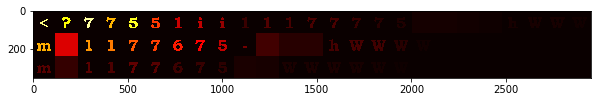

In [7]:
batch_size = np.shape(interest_np["targets"])[0]
idx = np.random.randint(0, batch_size)
print(idx)
raw_input = np.squeeze(interest_np["input"][idx])
raw_target = np.squeeze(interest_np["targets"][idx])
raw_output = np.squeeze(interest_np["output"][idx])
action_seq = interest_np["action_seq"][idx]
input_str = auxiliary_utils.instant_decode(encoders, raw_input).strip()
target_str = auxiliary_utils.instant_decode(encoders, raw_target, "targets").strip()
output_str = auxiliary_utils.instant_decode(encoders, raw_output).split("<EOS>")[0].strip()
print(f"input: {input_str}")
print(f"target: {target_str}")
print(f"output: {output_str}")
top_k = 1
vocab_size = encoders["inputs"].vocab_size
img_onehot = auxiliary_utils.emulate_NLA_by_one_hots(raw_input, action_seq, 25, 3, vocab_size)
final_image = auxiliary_utils.img_symbols(img_onehot, encoders, top_k=top_k)
fig = plt.figure(figsize=[10, 10])
plt.imshow(final_image, cmap='hot', interpolation='nearest', vmin=0, vmax=1)